In [ ]:
! pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
treino = pd.read_csv("data/train.csv")
teste = pd.read_csv("data/test.csv")

print("Conjunto de treino:", treino.shape)
print("Conjunto de teste:", teste.shape)

Conjunto de treino: (891, 12)
Conjunto de teste: (418, 11)


In [94]:
print("\nValores Nulos em Treino \n{}".format(treino.isnull().sum()))
print("\nValores Nulos em Teste \n{}".format(teste.isnull().sum()))


Valores Nulos em Treino 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Valores Nulos em Teste 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [95]:
print("\nValores Duplicados em Treino \n{}".format(treino.duplicated().sum()))
print("\nValores Duplicados em Teste \n{}".format(teste.duplicated().sum()))


Valores Duplicados em Treino 
0

Valores Duplicados em Teste 
0


In [102]:
# Preenchendo os dois valores ausentes em embarked com S, o porto de embarque mais comum.
treino["Embarked"] = treino["Embarked"].fillna(value="S")

In [103]:
# Preenchendo a tarifa com o valor médio das tarifas na base de teste
teste["Fare"] = teste["Fare"].fillna(value=teste.Fare.mean())

In [104]:
# Name
treino["Name"].head()
# Podemos analisar por título: Senhorita, Sr., Sra., Mestre, Dr e etc
treino["Name_Title"] = treino["Name"].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split()[0])
treino["Name_Title"].value_counts()

Name_Title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Ms.            1
Mme.           1
Don.           1
Lady.          1
Sir.           1
Capt.          1
the            1
Jonkheer.      1
Name: count, dtype: int64

In [105]:
# O mesmo para teste
teste["Name_Title"] = teste["Name"].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split()[0])
teste["Name_Title"].value_counts()

Name_Title
Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Ms.          1
Dr.          1
Dona.        1
Name: count, dtype: int64

In [106]:
# Olhando taxa de sobrevivência por título
treino["Survived"].groupby(treino["Name_Title"]).mean()

Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64

In [107]:
# A coluna Age possui muitos valores vazios e podemos preencher esses valores usando a média da idade dos passageiros pro título
treino["Age"] = treino.groupby(["Name_Title"])["Age"].transform(lambda x: x.fillna(x.mean()))
teste["Age"] = teste.groupby(["Name_Title"])["Age"].transform(lambda x: x.fillna(x.mean()))

### Cabin

A coluna Cabin possui quase 700 valores nulos, o que representa uma grande quantidade de dados faltantes.
Uma informação que podemos tirar dessa coluna é que a letra da cabine (primeira letra do valor em Cabin) parece estar associada à taxa de sobrevivência.
Ao extrair essa informação, vemos que a distribuição de letras é muito concentrada em valores nulos (n), seguido das letras C, B, D, e assim por diante.
Foi decidido excluir essa coluna

In [108]:
treino["Cabin_Letter"] = treino["Cabin"].apply(lambda x: str(x)[0])
treino["Cabin_Letter"].value_counts()

Cabin_Letter
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [109]:
# Média de sobreviventes por letra da cabine
treino["Survived"].groupby(treino["Cabin_Letter"]).mean()

Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

In [110]:
print(treino.columns)
print(teste.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Name_Title',
       'Cabin_Letter'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Name_Title'],
      dtype='object')


In [111]:
# Removendo colunas que não vamos precisar
treino = treino.drop(['Name','Ticket','PassengerId', 'Cabin', 'Name_Title', 'Cabin_Letter'], axis=1)
teste = teste.drop(['Name','Ticket','PassengerId', 'Cabin', 'Name_Title'], axis=1)
treino.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [112]:
# Mapeando recursos categóricos
categories = {"female": 1, "male": 0}
treino["Sex"]= treino["Sex"].map(categories)
teste["Sex"]= teste["Sex"].map(categories)

categories = {"S": 1, "C": 2, "Q": 3}
treino['Embarked']= treino['Embarked'].map(categories)
teste['Embarked']= teste['Embarked'].map(categories)

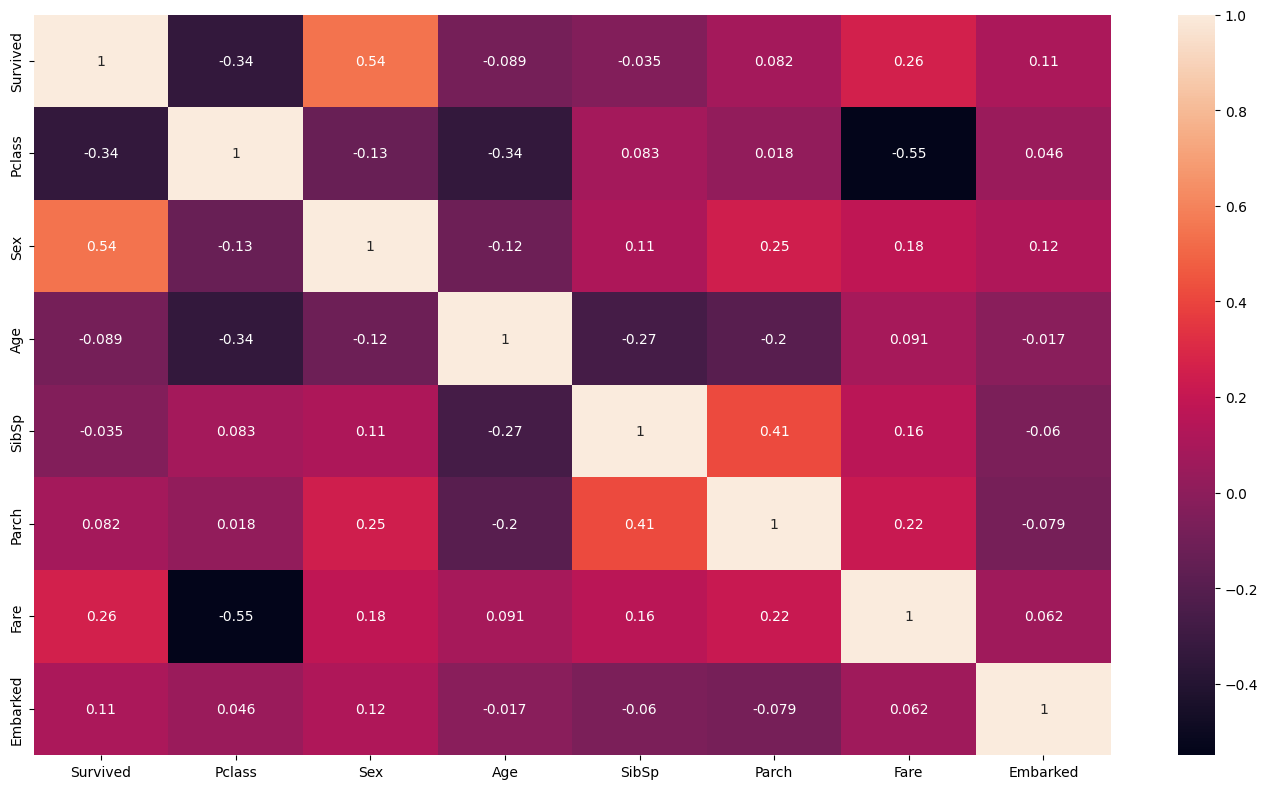

In [113]:
# Matriz de correlação
plt.figure(figsize=(14,8))
sns.heatmap(treino.corr(), annot=True)
plt.tight_layout()

In [114]:
# Normalizando os dados
from sklearn.preprocessing import MinMaxScaler

# Removendo o rótulo
LABEL = 'Survived'
y = treino[LABEL]
treino = treino.drop(LABEL, axis=1)  # Remover o rótulo para normalizar

escalonador = MinMaxScaler()
dados_normalizados_treino = escalonador.fit_transform(treino)
dados_normalizados_teste = escalonador.transform(teste)

dados_normalizados_treino = pd.DataFrame(dados_normalizados_treino, columns=treino.columns, index=treino.index)
dados_normalizados_teste = pd.DataFrame(dados_normalizados_teste, columns=teste.columns, index=teste.index)

dados_normalizados_treino.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0.0,0.271174,0.125,0.0,0.014151,0.0
1,0.0,1.0,0.472229,0.125,0.0,0.139136,0.5
2,1.0,1.0,0.321438,0.000,0.0,0.015469,0.0
3,0.0,1.0,0.434531,0.125,0.0,0.103644,0.0
4,1.0,0.0,0.434531,0.000,0.0,0.015713,0.0


In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(dados_normalizados_treino, y, test_size=0.2)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

(712, 7) (179, 7)
(712,) (179,)


RandomForestClassifier()

In [116]:
feature_imp = pd.Series(clf.feature_importances_, index=dados_normalizados_treino.columns).sort_values(ascending=False)

# Fazer previsões com o conjunto de teste
y_pred = clf.predict(X_test)

acuracia = metrics.accuracy_score(y_test, y_pred)
print("Acurácia: {:.4f}".format(acuracia))
print(classification_report(y_test,y_pred))

Acurácia: 0.8659
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       116
           1       0.83      0.78      0.80        63

    accuracy                           0.87       179
   macro avg       0.86      0.85      0.85       179
weighted avg       0.86      0.87      0.86       179



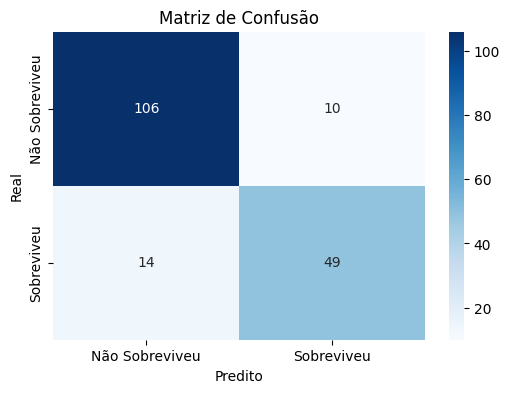

In [117]:
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Não Sobreviveu", "Sobreviveu"], yticklabels=["Não Sobreviveu", "Sobreviveu"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

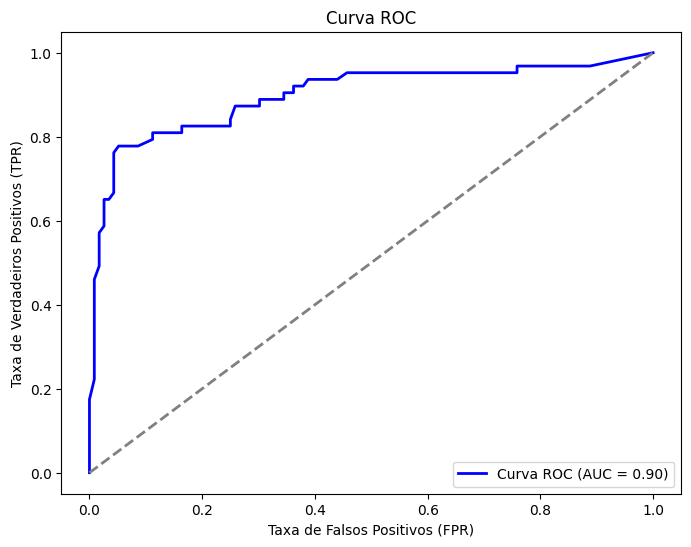

In [118]:
# Calcular as probabilidades de previsão para a classe positiva
y_prob = clf.predict_proba(X_test)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)

# Calcular a área sob a curva (AUC)
roc_auc = metrics.auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="b", lw=2, label="Curva ROC (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

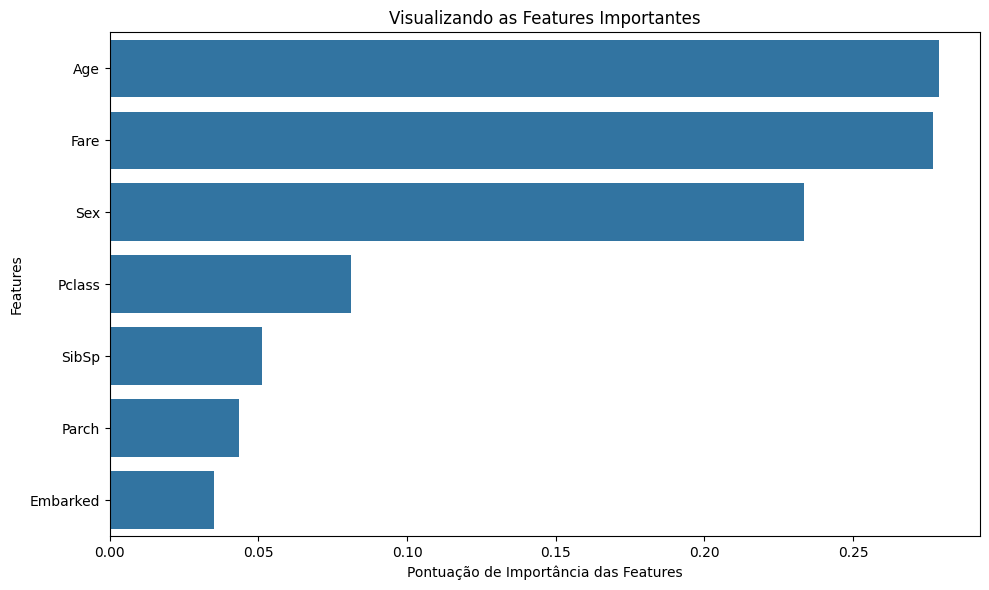

In [119]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Adicionar rótulos ao gráfico
plt.xlabel('Pontuação de Importância das Features')
plt.ylabel('Features')
plt.title("Visualizando as Features Importantes")
plt.tight_layout()

In [ ]:
# Removendo  features "menos importantes"

novo_treino = dados_normalizados_treino.drop(["Embarked", "Parch", "SibSp"], axis=1)
novo_teste = dados_normalizados_teste.drop(["Embarked", "Parch", "SibSp"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(novo_treino, y, test_size=0.2)
clf_novo = RandomForestClassifier(n_estimators=100)

#Treino do modelo
clf_novo.fit(X_train, y_train)

y_pred_2 = clf_novo.predict(X_test)

acuracia = metrics.accuracy_score(y_test, y_pred_2)
print("Acurácia: {:.4f}".format(acuracia))
print(classification_report(y_test,y_pred_2))



Acurácia: 0.8324
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       108
           1       0.82      0.75      0.78        71

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [121]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Ajuste de Hiperparâmetros
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Avaliação do Modelo
best_rf = grid_search.best_estimator_
y_pred_3 = best_rf.predict(X_test)
print(f"Acurácia: {metrics.accuracy_score(y_test, y_pred_3)}")
print(classification_report(y_test,y_pred_3))

Acurácia: 0.8715083798882681
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       112
           1       0.94      0.70      0.80        67

    accuracy                           0.87       179
   macro avg       0.89      0.84      0.85       179
weighted avg       0.88      0.87      0.87       179



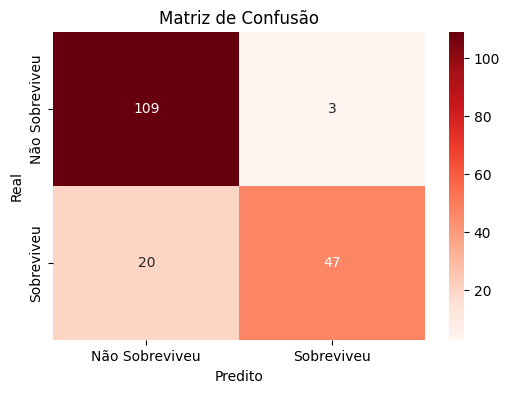

In [122]:
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_3)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=["Não Sobreviveu", "Sobreviveu"], yticklabels=["Não Sobreviveu", "Sobreviveu"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
_

In [ ]:
# Usando o SMOTE para balancear os dados
from imblearn.over_sampling import SMOTE

# Divida os dados entre variáveis independentes (X) e dependentes (y)
X = dados_normalizados_treino 

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Treinar o modelo com o conjunto de treino balanceado
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o modelo
acuracia = metrics.accuracy_score(y_test, y_pred)
print("Acurácia: {:.4f}".format(acuracia))
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


Acurácia: 0.8212
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       105
           1       0.77      0.81      0.79        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179

Matriz de Confusão:
[[87 18]
 [14 60]]


In [126]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(dados_normalizados_treino, y, test_size=0.2, random_state=42)

# Treinar o modelo com pesos balanceados automaticamente
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o modelo
acuracia = metrics.accuracy_score(y_test, y_pred)
print("Acurácia: {:.4f}".format(acuracia))
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


Acurácia: 0.8268
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Matriz de Confusão:
[[91 14]
 [17 57]]
